In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xzf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark==3.0.3

--2022-10-22 01:35:00--  https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299321244 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.0-bin-hadoop3.tgz’

spark-3.3.0-bin-had 100%[===================>] 285.45M   240MB/s    in 1.2s    

2022-10-22 01:35:01 (240 MB/s) - ‘spark-3.3.0-bin-hadoop3.tgz’ saved [299321244/299321244]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209.1 MB 62 kB/s 
     |████████████████████████████████| 198 kB 51.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.3-py2.py3-none-any.whl size=209435971 sha256=fcca9f9a02915407dda50144022bb04634828235b489f314a116516db2f20367
  Stored in directory: /root/.cache/pip/wheels/7e/6d/0a/6b0

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"

In [10]:
#@title Copy the Dataset into a local store.

#@title Download from: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
#@title (In Colab: the downloaded file is stored under "/content" folder)
#@title Dataset description can be found here: https://github.com/nytimes/covid-19-data




In [6]:
! wget https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

--2022-10-22 01:36:03--  https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104795654 (100M) [text/plain]
Saving to: ‘us-counties.csv’

us-counties.csv     100%[===================>]  99.94M   320MB/s    in 0.3s    

2022-10-22 01:36:06 (320 MB/s) - ‘us-counties.csv’ saved [104795654/104795654]



In [ ]:
#@title Start your program


In [7]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession

In [8]:
#@title Create a Spark Session

In [9]:
conf = SparkConf().set('spark.ui.port', '4050')
#sc = SparkContext(conf=conf)
spark = SparkSession.builder.master('local[*]').getOrCreate()

In [15]:
#@title Load dateset into a dataframe

In [10]:
# Load the dataset
# NOTE: Fix your dataset location in case you run locally on your machine
data = spark.read.load('/content/us-counties.csv', format='csv', inferSchema=True, header=True)

# Print schema
data.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: integer (nullable = true)
 |-- cases: integer (nullable = true)
 |-- deaths: integer (nullable = true)



In [11]:
# No of rows in the dataset
data.count()

2502832

In [12]:
# display first 10 rows of the dataset
data.show(10)

+-------------------+-----------+----------+-----+-----+------+
|               date|     county|     state| fips|cases|deaths|
+-------------------+-----------+----------+-----+-----+------+
|2020-01-21 00:00:00|  Snohomish|Washington|53061|    1|     0|
|2020-01-22 00:00:00|  Snohomish|Washington|53061|    1|     0|
|2020-01-23 00:00:00|  Snohomish|Washington|53061|    1|     0|
|2020-01-24 00:00:00|       Cook|  Illinois|17031|    1|     0|
|2020-01-24 00:00:00|  Snohomish|Washington|53061|    1|     0|
|2020-01-25 00:00:00|     Orange|California| 6059|    1|     0|
|2020-01-25 00:00:00|       Cook|  Illinois|17031|    1|     0|
|2020-01-25 00:00:00|  Snohomish|Washington|53061|    1|     0|
|2020-01-26 00:00:00|   Maricopa|   Arizona| 4013|    1|     0|
|2020-01-26 00:00:00|Los Angeles|California| 6037|    1|     0|
+-------------------+-----------+----------+-----+-----+------+
only showing top 10 rows



In [13]:
#@title Task 0

In [14]:
from pyspark.sql import functions as F

# Add the cases for all counties for each day, aggregated by day.
daily_cumulative = data.groupby('date').agg(F.sum('cases').alias('total_cases'))
daily_cumulative = daily_cumulative.sort('date')
daily_cumulative.show(10)

# Plot data by converting a Spark dataframe to a Panda dataframe.
plot_data = daily_cumulative.toPandas()
dates = plot_data['date']
values = plot_data['total_cases']

# Discover daily news cases from total cases
daily_cases = [values[i+1] - values[i] for i in range(len(values)-1)]
ddates = [dates[i+1] for i in range(len(values)-1)]

+-------------------+-----------+
|               date|total_cases|
+-------------------+-----------+
|2020-01-21 00:00:00|          1|
|2020-01-22 00:00:00|          1|
|2020-01-23 00:00:00|          1|
|2020-01-24 00:00:00|          2|
|2020-01-25 00:00:00|          3|
|2020-01-26 00:00:00|          5|
|2020-01-27 00:00:00|          5|
|2020-01-28 00:00:00|          5|
|2020-01-29 00:00:00|          5|
|2020-01-30 00:00:00|          6|
+-------------------+-----------+
only showing top 10 rows



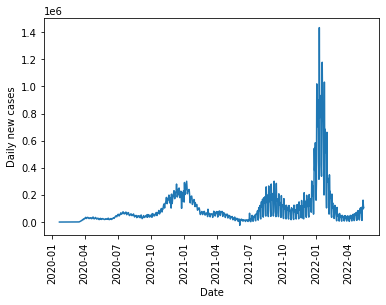

In [15]:
# Plot the dates of the daily cases.
import matplotlib.pyplot as plt
import numpy as np

plt.plot(ddates, daily_cases)
plt.xlabel('Date')
plt.ylabel('Daily new cases')
plt.xticks(rotation=90)
plt.show()

In [16]:
#@title Now, solve the following tasks.
#@title Feel free to add more code blocks within each task to spereate the code for better clarity and understanding

In [17]:
#@title Task 1: Find the total number of new cases added in the entire US in the month of March 2020.

In [18]:
from pyspark.sql.functions import year, month, dayofmonth,col

march_info = data.withColumn('day', dayofmonth(col('date')))
march_info = march_info.withColumn('month', month(col('date')))
march_info = march_info.withColumn('year', year(col('date')))

march_info.count()

2502832

In [19]:
march_data_modified=march_info.filter((march_info['month']==3) & (march_info['year']==2020) | ((march_info['month']==2) & (march_info['year']==2020) & (march_info['day']==29)))
march_data_grouped = march_data_modified.groupBy('date').sum('cases')
march_data_sorted = march_data_grouped.sort('date')
march_data_sorted.show()

+-------------------+----------+
|               date|sum(cases)|
+-------------------+----------+
|2020-02-29 00:00:00|        70|
|2020-03-01 00:00:00|        88|
|2020-03-02 00:00:00|       104|
|2020-03-03 00:00:00|       125|
|2020-03-04 00:00:00|       161|
|2020-03-05 00:00:00|       228|
|2020-03-06 00:00:00|       311|
|2020-03-07 00:00:00|       428|
|2020-03-08 00:00:00|       547|
|2020-03-09 00:00:00|       748|
|2020-03-10 00:00:00|      1018|
|2020-03-11 00:00:00|      1263|
|2020-03-12 00:00:00|      1668|
|2020-03-13 00:00:00|      2224|
|2020-03-14 00:00:00|      2898|
|2020-03-15 00:00:00|      3600|
|2020-03-16 00:00:00|      4507|
|2020-03-17 00:00:00|      5906|
|2020-03-18 00:00:00|      8350|
|2020-03-19 00:00:00|     12393|
+-------------------+----------+
only showing top 20 rows



In [20]:
march_df = march_data_sorted.toPandas()
cases = march_df['sum(cases)']
cases.count()

32

In [21]:
new_cases = [cases[i]-cases[i-1] for i in range(1,len(cases))]
len(new_cases)

31

In [22]:
total_new_cases = sum(new_cases)
total_new_cases

188391

In [35]:
#@title Task 2: Calculate the total new cases added in three consecutive months of June, July, and August of 2020 in Jackson county, Missouri (fips code 29095).

In [36]:
#@title Output will be like this:

#@title June 2020 cases

#@title July 2020 cases

#@title August 2020 cases

In [23]:
march_info.count()

2502832

In [24]:
filtered_data=march_info.filter((march_info['fips']==29095) & (march_info['year']==2020))
filtered_data

DataFrame[date: timestamp, county: string, state: string, fips: int, cases: int, deaths: int, day: int, month: int, year: int]

In [25]:
import pandas as pd
data = [['June 2020',0],['July 2020',0],['August 2020',0]]

In [26]:
june_data=filtered_data.filter((filtered_data['month']==6) & (filtered_data['year']==2020) | ((filtered_data['month']==5) & (filtered_data['year']==2020) & (filtered_data['day']==31)))
june_data_sorted = june_data.sort('date')
june_df = june_data_sorted.toPandas()
june_cases = june_df['cases']
june_new_cases = [june_cases[i]-june_cases[i-1] for i in range(1,len(june_cases))]
june_total_new_cases = sum(june_new_cases)
data[0][1]  = june_total_new_cases

In [27]:
july_data=filtered_data.filter((filtered_data['month']==7) & (filtered_data['year']==2020) | ((filtered_data['month']==6) & (filtered_data['year']==2020) & (filtered_data['day']==30)))
july_data_sorted = july_data.sort('date')
july_df = july_data_sorted.toPandas()
july_cases = july_df['cases']
july_new_cases = [july_cases[i]-july_cases[i-1] for i in range(1,len(july_cases))]
july_total_new_cases = sum(july_new_cases)
data[1][1]  = july_total_new_cases

In [28]:
august_data=filtered_data.filter((filtered_data['month']==8) & (filtered_data['year']==2020) | ((filtered_data['month']==7) & (filtered_data['year']==2020) & (filtered_data['day']==31)))
august_data_sorted = august_data.sort('date')
august_df = august_data_sorted.toPandas()
august_cases = august_df['cases']
august_new_cases = [august_cases[i]-august_cases[i-1] for i in range(1,len(august_cases))]
august_total_new_cases = sum(august_new_cases)
data[2][1]  = august_total_new_cases

In [29]:
df=pd.DataFrame(data,columns=['Year','New Cases'])
df

,Year,New Cases
0,June 2020,614
1,July 2020,2110
2,August 2020,2201


In [46]:
#@title Task 3: Find the daily new cases per month per 1000 population in Missouri state (MO) since the beginning of the pandemic (assume MO's population is 6,154,913). [Plot the data]


In [30]:
march_info.count()

2502832

In [31]:
def monthly_new_cases(data):
  grouped_data = data.groupBy('date').sum('cases')
  sorted_data = grouped_data.sort('date')
  month_df = sorted_data.toPandas()
  month_cases = month_df['sum(cases)']
  month_new_cases = [month_cases[i]-month_cases[i-1] for i in range(1,len(month_cases))]
  return sum(month_new_cases)

In [32]:
mo_data_2020 = march_info.filter((march_info['state']=='Missouri') & (march_info['year']==2020))
mo_data_2021 = march_info.filter((march_info['state']=='Missouri') & (march_info['year']==2021))

In [33]:
monthly_data = []
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==3) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==2) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==29))))
monthly_data.append(['March 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==4) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==3) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==31))))
monthly_data.append(['April 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==5) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==4) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==30))))
monthly_data.append(['May 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==6) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==5) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==31))))
monthly_data.append(['June 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==7) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==6) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==30))))
monthly_data.append(['July 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==8) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==7) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==31))))
monthly_data.append(['August 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==9) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==8) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==31))))
monthly_data.append(['September 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==10) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==9) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==30))))
monthly_data.append(['October 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==11) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==10) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==31))))
monthly_data.append(['November 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2020.filter((mo_data_2020['month']==12) & (mo_data_2020['year']==2020) | ((mo_data_2020['month']==11) & (mo_data_2020['year']==2020) & (mo_data_2020['day']==30))))
monthly_data.append(['December 2020',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==1) & (mo_data_2021['year']==2021)))
monthly_data.append(['January 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==2) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==1) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==31))))
monthly_data.append(['February 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==3) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==2) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==28))))
monthly_data.append(['March 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==4) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==3) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==31))))
monthly_data.append(['April 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==5) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==4) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==30))))
monthly_data.append(['May 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==6) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==5) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==31))))
monthly_data.append(['June 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==7) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==6) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==30))))
monthly_data.append(['July 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==8) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==7) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==31))))
monthly_data.append(['August 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==9) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==8) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==31))))
monthly_data.append(['September 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==10) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==9) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==30))))
monthly_data.append(['October 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==11) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==10) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==31))))
monthly_data.append(['November 2021',total_cases,(total_cases*1000)/6154913])
total_cases=monthly_new_cases(mo_data_2021.filter((mo_data_2021['month']==12) & (mo_data_2021['year']==2021) | ((mo_data_2021['month']==11) & (mo_data_2021['year']==2021) & (mo_data_2021['day']==30))))
monthly_data.append(['December 2021',total_cases,(total_cases*1000)/6154913])
monthly_data

[['March 2020', 1349, 0.21917450336016123],
 ['April 2020', 6213, 1.0094375013911652],
 ['May 2020', 5734, 0.9316134931557928],
 ['June 2020', 8978, 1.458672120954431],
 ['July 2020', 28799, 4.679026332297467],
 ['August 2020', 35254, 5.72778201739001],
 ['September 2020', 43737, 7.1060305807734405],
 ['October 2020', 59860, 9.725563951919385],
 ['November 2020', 125056, 20.31807760727081],
 ['December 2020', 103656, 16.841180370867956],
 ['January 2021', 78313, 12.723656695066202],
 ['February 2021', 25070, 4.073168865262596],
 ['March 2021', 64300, 10.44693889255624],
 ['April 2021', 12010, 1.9512867200559942],
 ['May 2021', 14498, 2.3555166417461955],
 ['June 2021', 19325, 3.1397681819385586],
 ['July 2021', 60993, 9.909644539248564],
 ['August 2021', 79138, 12.857695957684536],
 ['September 2021', 62277, 10.118258373432736],
 ['October 2021', 35254, 5.72778201739001],
 ['November 2021', 49966, 8.118067631500233],
 ['December 2021', 100949, 16.401369117646343]]

In [34]:
import pandas as pd
df=pd.DataFrame(monthly_data,columns=['Month','New Cases','New cases per 1000 population'])
df

,Month,New Cases,New cases per 1000 population
0,March 2020,1349,0.219175
1,April 2020,6213,1.009438
2,May 2020,5734,0.931613
3,June 2020,8978,1.458672
4,July 2020,28799,4.679026
5,August 2020,35254,5.727782
6,September 2020,43737,7.106031
7,October 2020,59860,9.725564
8,November 2020,125056,20.318078
9,December 2020,103656,16.841180


In [35]:
#@title Task 5: Which single day in the year 2020 and 2021 had the largest number of deaths in the entire US (if there are multiple such dates, choose the earliest one)?


In [36]:
march_info.count()


2502832

In [37]:
filtered=march_info.filter((march_info['year']==2020) | (march_info['year']==2021))
grouped=filtered.groupBy('date').sum('deaths')
grouped=grouped.sort('date')
grouped_df = grouped.toPandas()
deaths = grouped_df['sum(deaths)']
per_day_deaths = [deaths[i]-deaths[i-1] for i in range(1,len(deaths))]
per_day_deaths.insert(0,0)
grouped_df['deaths'] = per_day_deaths
max_deaths = grouped_df['deaths'].max()
df = grouped_df[grouped_df['deaths']==max_deaths]
df

,date,sum(deaths),deaths
388,2021-02-12,480701,5463


In [38]:
#@title Task 4: On which date all 50 US states have at least 100 cases? At least one death?


In [39]:
march_info.count()

2502832

In [44]:
import pandas as pd
group_cases_of_state = march_info.groupBy('state','date').sum('cases')
date_grouped_cases = group_cases_of_state.groupBy('date').min('sum(cases)')

In [45]:
filtered_cases = date_grouped_cases.filter(date_grouped_cases['min(sum(cases))']>=100)

In [47]:
grouped_death_of_state = march_info.groupBy('state','date').sum('deaths')
date_grouped_deaths = grouped_death_of_state.groupBy('date').min('sum(deaths)')

In [48]:
filtered_deaths = date_grouped_deaths.filter(date_grouped_deaths['min(sum(deaths))']>=1)

In [49]:
cases_df = filtered_cases.toPandas()
deaths_df = filtered_deaths.toPandas()
inter_df = pd.merge(cases_df,deaths_df,how='inner',on='date')
required_date=inter_df['date'].min()

In [50]:
required_date

Timestamp('2020-11-09 00:00:00')

In [51]:
#@title For the above taks 
#@title In order to determine the number of cases and fatalities reported in each state for a given day, we first categorize data by state and date.
#@title Secondly, we filter the dates on which there have been at least 100 cases and at least one death reported in each state. 
#@title Finally, we analyzed the shared records across the two data frames and return the records with the earliest occurrence.